In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, learning_curve, KFold
import matplotlib.pyplot as plt
from typing import Tuple
import seaborn as sbr
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder

In [2]:
def label_encoder(train_df: pd.DataFrame, label_cols: list, mappings: dict = None):

    df_copy = train_df.copy()

    if not label_cols:
        return df_copy, None

    categories = []
    for col in label_cols:
        if mappings and col in mappings:
            categories.append(mappings[col])  # ordine personalizzato
        else:
            raise ValueError(f"Manca il mapping per la colonna {col}")

    encoder = OrdinalEncoder(categories=categories)
    df_copy[label_cols] = encoder.fit_transform(df_copy[label_cols])

    return df_copy, encoder

def cross_validate_kfold(model, X, y, k=5, random_state=0, shuffle=True, task="regression", preprocess="standardize"):

    kf = KFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    train_scores = []
    test_scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Standardizzazione per fold

        if preprocess == "standardize":
            scaler = StandardScaler()
        else:
            scaler = MinMaxScaler()

        X_train_std = scaler.fit_transform(X_train)
        X_test_std = scaler.transform(X_test)

        # Fit e predizioni
        model.fit(X_train_std, y_train)
        y_train_pred = model.predict(X_train_std)
        y_test_pred = model.predict(X_test_std)

        # Score
        if task == "classification":
            from sklearn.metrics import accuracy_score
            train_sc = accuracy_score(y_train, y_train_pred)
            test_sc = accuracy_score(y_test, y_test_pred)
        else:
            train_sc = r2_score(y_train, y_train_pred)
            test_sc = r2_score(y_test, y_test_pred)

        train_scores.append(train_sc)
        test_scores.append(test_sc)

    results = {
        'train_scores': np.array(train_scores),
        'test_scores': np.array(test_scores),
        'train_mean': np.mean(train_scores),
        'test_mean': np.mean(test_scores)
    }

    return results

def feature_analisi(df: pd.DataFrame, ordine: str = "% Nulli", ascending: bool = False) -> pd.DataFrame:
    """
    Ritorna info sulle colonne del DataFrame:
    - Tipo colonna
    - N. valori nulli
    - % valori nulli
    - N. valori unici
    - % valori unici
    - Valore minimo (per colonne numeriche)
    - Valore massimo (per colonne numeriche)

    Parametri:
    - ordine: colonna di ordinamento ("% Nulli" o "% Unici")
    - ascending: True per ordine crescente, False per decrescente (default)
    """
    n_rows = len(df)
    null_count = df.isnull().sum()
    null_percent = (null_count / n_rows) * 100
    dtypes = df.dtypes.astype(str)
    unique_count = df.nunique()
    unique_percent = (unique_count / n_rows) * 100

    # Calcolo minimo e massimo solo per colonne numeriche
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    min_values = df[numeric_cols].min().reindex(df.columns, fill_value=np.nan)
    max_values = df[numeric_cols].max().reindex(df.columns, fill_value=np.nan)

    risultato = pd.DataFrame({
        "Colonna": df.columns,
        "Tipo": dtypes,
        "N Nulli": null_count,
        "% Nulli": null_percent.round(2),
        "N Unici": unique_count,
        "% Unici": unique_percent.round(2),
        "Min": min_values,
        "Max": max_values
    })

    if ordine not in ["% Nulli", "% Unici"]:
        raise ValueError("Il parametro 'ordine' deve essere '% Nulli' oppure '% Unici'.")

    risultato = risultato.sort_values(by=ordine, ascending=ascending).reset_index(drop=True)

    return risultato

def DistribuzioneFeature(df: pd.DataFrame, feature: str, bins: int = 30, figsize: Tuple[int, int] = (8, 5)) -> None:
    """Istogramma della distribuzione di una feature numerica."""
    if feature not in df.columns:
        raise ValueError(f"La feature '{feature}' non è presente nel DataFrame.")
    col = feature  # o qualsiasi altra feature
    plt.figure(figsize=(8,5))
    sbr.histplot(df[col], bins=30, kde=True)  # kde=True aggiunge la curva stimata
    plt.title(f"Distribuzione di {col}")
    plt.xlabel(col)
    plt.ylabel("Frequenza")
    plt.show()

In [4]:
df = pd.read_csv('fruits.csv')
df

,Frutto,Peso (g),Diametro medio (mm),Lunghezza media (mm),Durezza buccia (1-10),Dolcezza (1-10)
0,Mela,86.40,89.68,8.69,9.61,2.41
1,Mela,77.58,73.45,6.49,7.20,3.87
2,Mela,81.95,81.66,6.40,9.09,2.88
3,Mela,66.33,36.71,6.78,8.21,2.55
4,Mela,56.73,75.69,5.78,9.15,3.88
...,...,...,...,...,...,...
495,Kiwi,40.82,67.52,7.39,7.28,5.56
496,Kiwi,54.65,62.95,7.06,6.47,4.68
497,Kiwi,35.70,71.43,7.64,9.75,4.36
498,Kiwi,30.80,65.23,5.91,7.65,4.13


In [5]:
feature_analisi(df)

,Colonna,Tipo,N Nulli,% Nulli,N Unici,% Unici,Min,Max
0,Frutto,object,0,0.0,5,1.0,NaN,NaN
1,Peso (g),float64,0,0.0,470,94.0,8.57,111.21
2,Diametro medio (mm),float64,0,0.0,487,97.4,7.53,299.89
3,Lunghezza media (mm),float64,0,0.0,373,74.6,1.15,11.14
4,Durezza buccia (1-10),float64,0,0.0,349,69.8,3.07,13.72
5,Dolcezza (1-10),float64,0,0.0,305,61.0,1.25,6.95


Nessun valore mancante, l'unica cosa che vedo è che Durezza e Dolcezza non sono della scala dichiarata. Durezza da 1 a 10, invece il massimo arriva a 13, Dolcezza invece da 1 a 10 invece arriva a masimo 7.

Per la Dolcezza va bene, non è come dichiarato ma arriva a massimo 7 (mancano dati? ma non è un nostro problema a questo punto)

Per Durezza non vorrei che ci fosse un Outlier, cioè un valore fuori scala, sono curioso di vedere la distrubuzione di questa

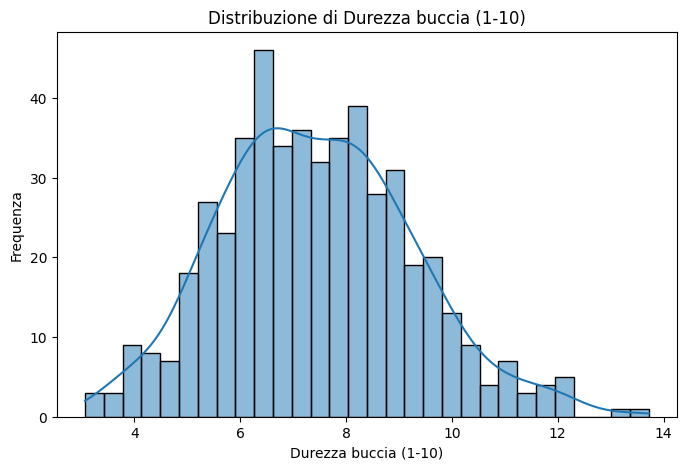

In [6]:
DistribuzioneFeature(df, 'Durezza buccia (1-10)')

Niente di strano, qualche outlier dopo il valore 12, mi verrebbe da tagliare i dati dopo il 10 pensando che sia un possibile errore di battitura dell'utente sinceramente per non sono convinto che sia corretto dal punto di vista dell'esercizio

Inoltre si potrebbe anche categorizzare sia Durezza che Dolcezza da valori continui a interi da 1 a 10 ma lascio fare tutto al modello.

In definitiva, suppongo che i dati siano stati correttamente inseriti dagli utenti e che non ci siano errori di digitazione

Dobbiamo invece decodificare la variabile target, visto che sono stringhe, usiamo label encoding

In [7]:
# Ora stampo la Feature Frutto aggregata per oggetti, per capire quanti e quali stringhe ci sono

df["Frutto"].value_counts()

Frutto
Mela       100
Banana     100
Arancia    100
Uva        100
Kiwi       100
Name: count, dtype: int64

In [8]:
map = {'Frutto': ["Arancia", "Banana", "Kiwi", "Mela", "Uva"]}
df, _ = label_encoder(df, ['Frutto'], map)

In [9]:
# Ora dividiamo, poi normalizziamo i dati per evitare data leakage

X = df.drop('Frutto', axis=1).values
y = df['Frutto'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#X_train, X_test, y_train, y_test = fml.SplitTrainTest(X=X,y=y,test_size=0.2,random_state=0)

scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

X_train_norm.shape

(400, 5)

In [10]:
Ks = [1,2,3,4,5,6,7,8,9,10]

for k in Ks:
  #KNN=fml.get_model("KNN", n_neighbors=k )
  KNN = KNeighborsClassifier(n_neighbors=k)
  KNN.fit(X_train_norm,y_train)
  yhat=KNN.predict(X_test_norm)
  print("K: ", k)
  print("Train set Accuracy: ", metrics.accuracy_score(y_train, KNN.predict(X_train_norm)))
  print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

# K = 9 mi sembra il migliore perche ha la miglior accuracy su Test set e allo stesso un ottima accuracy su quello di train. Con K=1 invece mi da sensazione di overfitting visto che accuracy su train = 1

K:  1
Train set Accuracy:  1.0
Test set Accuracy:  0.89
K:  2
Train set Accuracy:  0.9625
Test set Accuracy:  0.85
K:  3
Train set Accuracy:  0.9725
Test set Accuracy:  0.89
K:  4
Train set Accuracy:  0.9475
Test set Accuracy:  0.88
K:  5
Train set Accuracy:  0.9475
Test set Accuracy:  0.9
K:  6
Train set Accuracy:  0.9375
Test set Accuracy:  0.87
K:  7
Train set Accuracy:  0.935
Test set Accuracy:  0.88
K:  8
Train set Accuracy:  0.9375
Test set Accuracy:  0.87
K:  9
Train set Accuracy:  0.94
Test set Accuracy:  0.91
K:  10
Train set Accuracy:  0.94
Test set Accuracy:  0.9


Il modello sarebbe pronto, pero voglio anche vedere se generalizza con Cross Validation, quindi diversi tagli del dataset

Devo prendere i dati prima della normalizzazione, in quando devono essere normalizzati per ogni gruppo differentemente

In [11]:
modello = KNeighborsClassifier(n_neighbors=9)
cross_validate_kfold(modello, X, y, k=5, random_state=0, task="classification", preprocess="normalize")

{'train_scores': array([0.94  , 0.945 , 0.945 , 0.9375, 0.9375]),
 'test_scores': array([0.91, 0.9 , 0.94, 0.94, 0.95]),
 'train_mean': np.float64(0.9410000000000001),
 'test_mean': np.float64(0.9279999999999999)}

Anche cambiando test e train in 5 fold, le prestazioni rimangono molto buone, quindi direi che è un modello molto generalizzato

Creo anche la funzione che prende in input il nuovo dato e usando il modello stampa la classe predetta e tutte le probabilità, ovviamente la classe predetta sarà decodificata per dare in output il nome reale della classe

In [12]:
def Prevedi_classe(modello,X_nuovo,encoder):

  modello.fit(X_train_norm,y_train)
  X_nuovo_norm = scaler.transform(X_nuovo.reshape(1, -1))
  y=modello.predict(X_nuovo_norm)

  # Ora decodifichiamo la previsione da numero a stringa
  y_decoficato = encoder.inverse_transform(y.reshape(-1, 1))

  print("Classe predetta: ", y_decoficato[0][0])

  # Ottieni le probabilità
  probabilita = modello.predict_proba(X_nuovo_norm)[0]

  # Stampa le probabilità per ogni classe (solo quelle diverse da 0)
  classi = encoder.categories_[0] # Ottieni i nomi delle classi dall'encoder
  print("Probabilità per ogni classe (diversa da 0):")
  for i, prob in enumerate(probabilita):
    if prob > 0:
      print(f"  {classi[i]}: {prob:.4f}")

In [13]:
# Faccio un esempio con un frutto gia esistente nel database, poi pero la funzione puo essere utilizzata dall'azienda per valutare i nuovi frutti esotici

Prevedi_classe(modello,X[496],_)

Classe predetta:  Arancia
Probabilità per ogni classe (diversa da 0):
  Arancia: 0.7778
  Kiwi: 0.2222
